# Learning Acousticc Word Embeddings with Soft-DTW Triplet Network

This notebook aims to evaluate the effect of learning Acoustic Word Embeddings (AWEs) with Soft-DTW triplet network. Soft-DTW triplet network is an embedding model for time-series such as speech audio. Typical acoustic embedding model outputs fixed-size embeddings for input speech of arbitrary length. Soft-DTW triplet network outputs embeddings for each timestep of the input, thus embeddings vary in length. To compare embeddings of two samples, Soft-DTW algorithm can be used. 

Soft-DTW algorithm finds optimal alighnment between 2 time-series and can mitigate issues caused by any kind of temporal distortions in the original signal. Soft-DTW triplet network uses Soft-DTW in its loss function. After training embeddings obtained with this model can be used for tasks such as spoken word discrimination, Query-by-Example (QbE).

This notebook demonstrates resulting performance of the Soft-DTW triplet network on the word discrimination task. In the word discrimination task, the model gets two spoken words as input and has to decide whether these two words are the same or different. 

[SpeechCommands](https://ai.googleblog.com/2017/08/launching-speech-commands-dataset.html) dataset was used to train and evaluate performance of the embedding model.

In [1]:
import numpy as np
from scipy.spatial.distance import euclidean, minkowski
from sklearn.metrics import precision_recall_curve, average_precision_score
import scipy
import torch
import yaml
from pprint import pprint

import dtwalign

from src.audio_processing import AudioPreprocessorMFCCDeltaDelta
from src.data_collector import  SiameseSpeechCommandsDataCollector 
from src.model import SiameseDeepLSTMNet
from src.soft_dtw import SoftDTW

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
sns.set()
sns.set(font_scale=1.4, rc={'text.usetex' : False})
sns.set_style("whitegrid")

%matplotlib inline

np.random.seed(1234)

In [2]:
#constants
DISTANCE='minkowski'
STEP_PATTERN = 'symmetric1'

First specify path to the config file and model

In [3]:
config_path = r'C:\Study\Soft-DTW-AWE\saved_models\config.yaml'
model_path = r'C:\Study\Soft-DTW-AWE\saved_models\net_49000.net'

Load and print config

In [4]:
with open(config_path, 'r') as data_file:
    config = yaml.safe_load(data_file)
pprint(config)

{'data_root': 'C:\\Study\\Soft-DTW-AWE\\speech_dataset',
 'labels': ['bed',
            'bird',
            'cat',
            'dog',
            'down',
            'eight',
            'five',
            'four',
            'go',
            'happy',
            'house',
            'left',
            'marvin',
            'nine',
            'no',
            'off',
            'on',
            'one',
            'right',
            'seven',
            'sheila',
            'six',
            'stop',
            'three',
            'tree',
            'two',
            'up',
            'wow',
            'yes',
            'zero'],
 'loss': {'alpha': 0.0,
          'dist': 'l1',
          'margin': 0.4,
          'open_end': False,
          'triplet_anneal_b': 2500,
          'triplet_anneal_k': 0.0025,
          'type': 'sdtw'},
 'model': {'batch_norm': True,
           'bidirectional': False,
           'dropout': 0.3,
           'hidden_fc': [256, 256],
           'hidde

## 1. Gather data

Create data preprocessing and data iterator based on the config

In [5]:
preproc = AudioPreprocessorMFCCDeltaDelta(numcep=config['preprocessing']['numcep'],
                                          winlen=config['preprocessing']['winlen'],
                                          winstep=config['preprocessing']['winstep'])

data_iter = SiameseSpeechCommandsDataCollector(preproc,
                                        data_dir=config['data_root'],
                                        wanted_words=config['labels'],
                                        testing_percentage=10,
                                        validation_percentage=10
                                        )

index_to_word = {v:k for k,v in data_iter.word_to_index.items()}

Gather a batch of 2000 triplets. Have a look at the data. Each triplet containes 3 samples, where two samples have the same label and the other one has a different class label. Elements in such a triplet are called anchor, positive, negative. Anchor and positve samples have the same class label and form a 'positive' pair. Anchor and negative samples have different class labels and form a 'negative' pair.

In [6]:
n_mini_batch_size = 2000

data = data_iter.get_data(n_mini_batch_size, 0, 'validation')
labels = data['y']

duplicates = data_iter.get_duplicates(labels, 0, 'validation')
assert np.any(labels == duplicates['y'])

non_duplicates = data_iter.get_nonduplicates(labels, 0, 'validation')
assert np.any(labels != non_duplicates['y'])

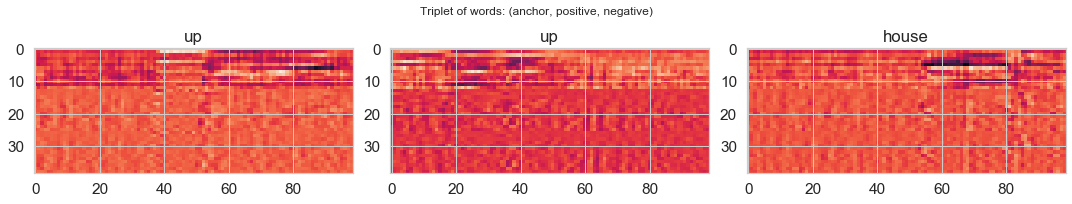

In [7]:
sample_idx = np.random.randint(data['y'].shape[0])

vmax = max([np.max(data['x'][sample_idx]),
            np.max(duplicates['x'][sample_idx]),
            np.max(non_duplicates['x'][sample_idx])])

fig, axes = plt.subplots(1, 3, figsize=(15,3))
# plot anchor
im = axes[0].imshow(data['x'][sample_idx].T, vmax=vmax)
label = index_to_word[data['y'][0]]
axes[0].title.set_text(f'{label}')
# plot positive sample
axes[1].imshow(duplicates['x'][sample_idx].T, vmax=vmax)
label = index_to_word[data['y'][0]]
axes[1].title.set_text(f'{label}')
# plot negative sample 
axes[2].imshow(non_duplicates['x'][sample_idx].T, vmax=vmax)
label = index_to_word[non_duplicates['y'][0]]
axes[2].title.set_text(f'{label}')

fig.suptitle('Triplet of words: (anchor, positive, negative)')
fig.tight_layout()
plt.show()


Compute DTW distance and plot alignments first for anchor and poistive sample and then for anchor and negative sample.

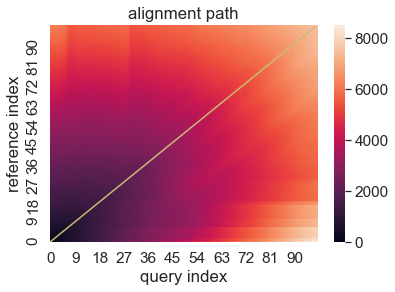

DTW distance between samples of the same label: 7552.8029


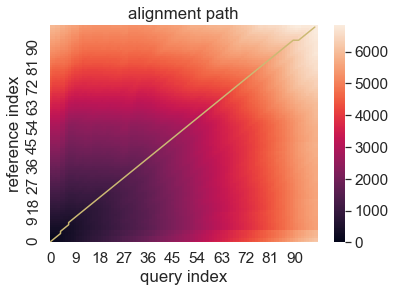

DTW distance between samples of different labels: 6838.5635


In [8]:
x = data['x'][sample_idx]

# positive dtw

y = duplicates['x'][sample_idx]
res = dtwalign.dtw(x, y, dist=DISTANCE, step_pattern=STEP_PATTERN, open_end=False)
res.plot_path()
print(f"DTW distance between samples of the same label: {res.distance:.4f}")

# negative dtw

y = non_duplicates['x'][sample_idx]
res = dtwalign.dtw(x, y, dist=DISTANCE, step_pattern=STEP_PATTERN, open_end=False)
res.plot_path()
print(f"DTW distance between samples of different labels: {res.distance:.4f}")
plt.show()

It can be seen that DTW distance between positive pair is smaller compared to DTW distance between anchor and negative sample.

Few data samples gives us an idea of how the data looks like. However, to see the whole picture, we should sample a fairly big batch of samples and compare them with each other.

Just like a few steps before compute DTW distance for a positive pair and a negative pair for each triplet. This gives us 2 DTW distances for each triplet resulting in 4000 DTW distances to analyze. 

## 3. DTW distribution on raw data

Compute DTW distances and store them in separate collections for positive and negative pairs

In [9]:

# initialize dist_lists

mfcc_duplicates_dtw = []
mfcc_non_duplicates_dtw = []

for i in range(n_mini_batch_size):
    print(i, end='\r')
    x = data['x'][i].squeeze()
    
    y_duplicate = duplicates['x'][i].squeeze()
    mfcc_duplicates_dtw.append(dtwalign.dtw(x, y_duplicate, dist=DISTANCE, step_pattern=STEP_PATTERN, open_end=False, dist_only=True).distance)

    y_non_duplicate = non_duplicates['x'][i].squeeze()
    mfcc_non_duplicates_dtw.append(dtwalign.dtw(x, y_non_duplicate, dist=DISTANCE, step_pattern=STEP_PATTERN, open_end=False, dist_only=True).distance)    

Plot histograms to see how DTW distance is distributed.

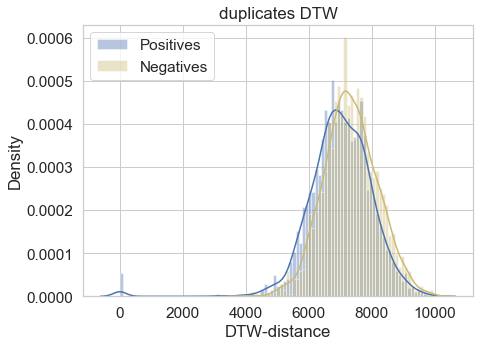

In [10]:
bins = np.linspace(0., max(np.max(mfcc_duplicates_dtw), np.max(mfcc_non_duplicates_dtw)), num=100)
fig, axes = plt.subplots(1, 1, figsize=(7,5))

sns.distplot(mfcc_duplicates_dtw,  bins=bins, ax=axes, label="Positives")
axes.title.set_text('duplicates DTW')

sns.distplot(mfcc_non_duplicates_dtw, bins=bins,  color='y', ax=axes, label="Negatives")
axes.legend()
plt.xlabel('DTW-distance')
plt.ylabel('Density')
plt.show()

As it can bee seen, resulting distributions look very much alike. It means that DTW distance between preprocessed audio samples doesn't tell us much about whether two samples are of the same class or not.

### KL Divergence between two DTW distributions:

Compute KL-divergence between two resulting distributions. This gives a quantitative estimate of how well we can discriminate between similar and different samples using just preprocessed data.

In [11]:
hist_dup, _ = np.histogram(mfcc_duplicates_dtw, bins=bins)
hist_dup = hist_dup / np.sum(hist_dup)

hist_non_dup, _ = np.histogram(mfcc_non_duplicates_dtw, bins=bins)
hist_non_dup = hist_non_dup / np.sum(hist_non_dup)

dkl = scipy.special.kl_div(hist_dup+1e-8, hist_non_dup+1e-8).sum()
print(f"DKL is: {dkl:.4f}")


DKL is: 0.2570


As it can be seen, DTW calculated on MFCCs signals failed to capture different and similar samples showing no significant difference between positive and negative pairs. Kullback-Leibler divergence just proves this fact that these two distributions have no significant difference.

## 4. Load Soft-DTW triplet network and compute embeddings

In [12]:
net = torch.load(model_path, map_location=torch.device('cpu'))
net.eval()

SiameseDeepLSTMNet(
  (_SiameseDeepLSTMNet__dropout): Dropout(p=0.3, inplace=False)
  (_SiameseDeepLSTMNet__bn1): BatchNorm1d(39, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lstms): ModuleList(
    (0): LSTM(39, 256, batch_first=True)
    (1): LSTM(256, 256, batch_first=True)
  )
  (linears): ModuleList(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=256, bias=True)
  )
  (_SiameseDeepLSTMNet__output_layer): Linear(in_features=512, out_features=1, bias=True)
  (_SiameseDeepLSTMNet__output_layer_cce): Linear(in_features=256, out_features=32, bias=True)
)

Compute embeddings for the same batch of triplets

In [13]:
embeds, _ = net.single_forward(torch.from_numpy(data['x']).float())
embeds = embeds.cpu().detach().numpy()

duplicates_embeds, _ = net.single_forward(torch.from_numpy(duplicates['x']).float())
duplicates_embeds = duplicates_embeds.detach().numpy()

non_duplicates_embeds, _ = net.single_forward(torch.from_numpy(non_duplicates['x']).float())
non_duplicates_embeds = non_duplicates_embeds.cpu().detach().numpy()

Plot alignments for the same triplet as before except this time DTW distance is computed between embeddings rather than MFCC. 

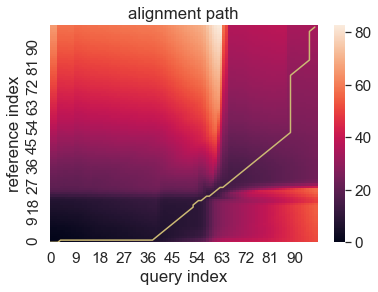

DTW distance between samples of the same label: 34.2764


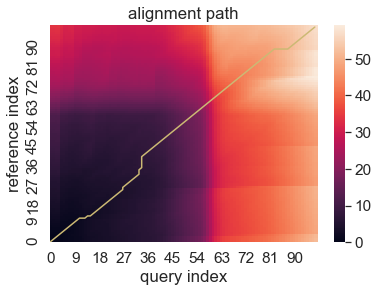

DTW distance between samples of different labels: 57.1486


In [14]:
x = embeds[sample_idx].squeeze()

# positive dtw

y = duplicates_embeds[sample_idx].squeeze()
res = dtwalign.dtw(x, y, dist=DISTANCE, step_pattern=STEP_PATTERN, open_end=False)
res.plot_path()
print(f"DTW distance between samples of the same label: {res.distance:.4f}")

# negative dtw

y = non_duplicates_embeds[sample_idx].squeeze()
res = dtwalign.dtw(x, y, dist=DISTANCE, step_pattern=STEP_PATTERN, open_end=False)
res.plot_path()
print(f"DTW distance between samples of different labels: {res.distance:.4f}")
plt.show()

## 5. DTW distribution on embeddings

Compute embeddings of all samples in the same batch and compare positive and negative pairs using DTW algorithm just as before.

In [15]:
duplicates_dtw = []
non_duplicates_dtw = []
for i in range(embeds.shape[0]):
# for i in range(500):

    print(i, end='\r')
    x = embeds[i].squeeze()
    
    y_duplicate = duplicates_embeds[i].squeeze()
    duplicates_dtw.append(dtwalign.dtw(x, y_duplicate, dist=DISTANCE, step_pattern=STEP_PATTERN, open_end=False, dist_only=True).distance)

    y_non_duplicate = non_duplicates_embeds[i].squeeze()
    non_duplicates_dtw.append(dtwalign.dtw(x, y_non_duplicate, dist=DISTANCE, step_pattern=STEP_PATTERN, open_end=False, dist_only=True).distance)    

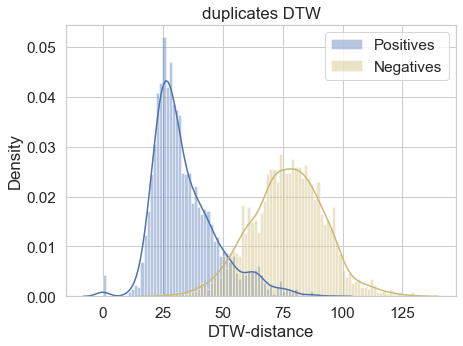

In [16]:
bins = np.linspace(0, max(np.max(duplicates_dtw), np.max(non_duplicates_dtw)), num=100)
fig, axes = plt.subplots(1, 1, figsize=(7,5))

sns.distplot(duplicates_dtw,  bins=bins, ax=axes, label="Positives")
axes.title.set_text('duplicates DTW')

sns.distplot(non_duplicates_dtw, bins=bins,  color='y', ax=axes, label="Negatives")
axes.legend()

plt.xlabel('DTW-distance')
plt.ylabel('Density')
plt.show()

It is clear by looking at the graph that now "positive" and "negative" distributions are far apart from each other. DTW distance for positive pairs has is centered at around 25 compared to 70 for negative pairs. More importantly, these two distributions have much smaller overlap compared to when MFCC is used. 

In [17]:
# compute kl divergence
hist_dup, _ = np.histogram(duplicates_dtw, bins=bins)
hist_dup = hist_dup / np.sum(hist_dup)

hist_non_dup, _ = np.histogram(non_duplicates_dtw, bins=bins)
hist_non_dup = hist_non_dup / np.sum(hist_non_dup)

dkl = scipy.special.kl_div(hist_dup+1e-8, hist_non_dup+1e-8).sum()
print(f"DKL is: {dkl:.4f}")

DKL is: 7.1065


## Precision Recall Curve

The main goal of the proposed embedding model is to be used to solve the  word  discrimination  task. To decide whether two samples belong to the same class, we compute the DTW distance betwwen their embeddings. the distance is lower than a specified threshold then samples are considered to be of the same class and different otherwise. By sweeping the threshold, a precision-recall curve is obtained and ,finally, Average Precision (AP) is computed.

In [18]:
dists_score = np.concatenate([duplicates_dtw, non_duplicates_dtw])
mfcc_dists_score = np.concatenate([mfcc_duplicates_dtw, mfcc_non_duplicates_dtw])
y_true = [0]*len(duplicates_dtw) + [1]*len(duplicates_dtw)

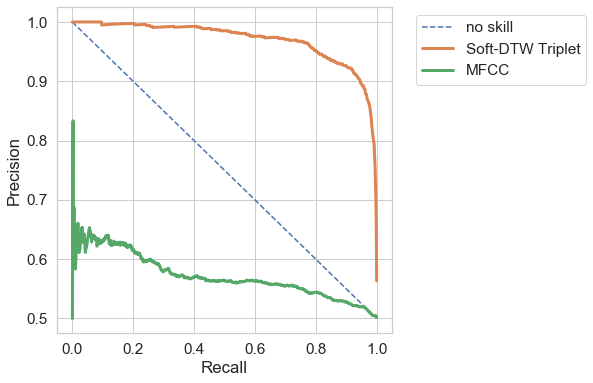

In [19]:
plt.figure(figsize=(6,6))

# no skill model
precision, recall, _ = precision_recall_curve(y_true, np.zeros(len(y_true)), pos_label=1)
ax = sns.lineplot(recall, precision, label='no skill')
ax.lines[0].set_linestyle("--")

precision, recall, thresholds = precision_recall_curve(y_true, dists_score, pos_label=1)
ax = sns.lineplot(recall, precision, label='Soft-DTW Triplet', linewidth=3, ci =None )

precision, recall, thresholds = precision_recall_curve(y_true, mfcc_dists_score, pos_label=1)
ax = sns.lineplot(recall, precision, label='MFCC', linewidth=3, ci =None )

plt.ylabel('Precision')
plt.xlabel('Recall')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.show()

In [20]:
sdtw_average_precision = average_precision_score(y_true, dists_score)
mfcc_average_precision = average_precision_score(y_true, mfcc_dists_score)

print(f"Soft-DTW AP={sdtw_average_precision:.4f}\nMFCC AP={mfcc_average_precision:.4f}")

Soft-DTW AP=0.9703
MFCC AP=0.5727


As it can be seen, the discrimination between words in this dataset can be significatnly improved with the proposed model, reaching AP=0.97.